In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.io as sio

from pathlib import Path
from matplotlib import pyplot as plt

import altair as alt
from altair.expr import datum

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
%load_ext watermark

In [3]:
%watermark --iversions

ipywidgets7.2.1
matplotlib3.0.1
scipy     1.1.0
altair    2.1.0
numpy     1.15.4
pandas    0.23.4



In [4]:
%matplotlib inline

# 0. Utility functions
- Define function that flattens the output from scipy.io.loadmat 
- Set paths to `data` folder
- Load dataframes with ID -> BiGG ID conversion table
- Define functions that help to load relevant experimental data from each simulation

In [5]:
from utils import (
    get_khodayari_kos,
    get_millard_kos,
    get_kurata_kos,
    get_chassagnole_kos,
    load_khodayari,
    load_kurata,
    load_millard,
    load_chassagnole,
    loadmat
)

In [6]:
# useful metrics to compare data
from utils import relative_error, normalized_error

In [7]:
data_path = Path('../data')
path_to_results = data_path / "simulation_results"
khodayari_path = path_to_results / "Khodayari"
millard_path = path_to_results / "Millard"
kurata_path = path_to_results / "Kurata"
chassagnole_path = path_to_results / "Chassagnole"

In [8]:
# Load ID dataframes
khod_idf = pd.read_csv(data_path / "khodayari_id.csv")
millard_idf = pd.read_csv(data_path / "millard_id.csv")
kurata_idf = pd.read_csv(data_path / "kurata_id.csv")
chassagnole_idf = pd.read_csv(data_path / "chassagnole_id.csv")

# 1. Load the simulation data

In [9]:
khodayari_results = load_khodayari(
    sample_names="all",
    load_path=khodayari_path,
    id_df=khod_idf,
    files=get_khodayari_kos(),
)

Loaded data file for sample fbaA which has flux matrix of (786, 2)
Loaded data file for sample fbaB which has flux matrix of (786, 2)
Loaded data file for sample fbp which has flux matrix of (786, 97)
Loaded data file for sample gnd which has flux matrix of (786, 7)
Loaded data file for sample pfkA which has flux matrix of (786, 6)
Loaded data file for sample pfkB which has flux matrix of (786, 6)
Loaded data file for sample pgi which has flux matrix of (786, 5)
Loaded data file for sample pgl which has flux matrix of (786, 2)
Loaded data file for sample ppsA which has flux matrix of (786, 2)
Loaded data file for sample pts which has flux matrix of (786, 7)
Loaded data file for sample pykA which has flux matrix of (786, 2)
Loaded data file for sample pykF which has flux matrix of (786, 2)
Loaded data file for sample rpe which has flux matrix of (786, 2)
Loaded data file for sample rpiA which has flux matrix of (786, 7)
Loaded data file for sample rpiB which has flux matrix of (786, 7)


In [10]:
kurata_results = load_kurata(
    sample_names="all", load_path=kurata_path, id_df=kurata_idf, files=get_kurata_kos()
)

Loaded data file for sample fbaA which has flux matrix of (2101, 155)
Loaded data file for sample fbaB which has flux matrix of (2101, 155)
Loaded data file for sample fbp which has flux matrix of (2101, 155)
Loaded data file for sample gnd which has flux matrix of (2101, 155)
Loaded data file for sample gpmA which has flux matrix of (2101, 155)
Loaded data file for sample pfkA which has flux matrix of (2101, 155)
Loaded data file for sample pfkB which has flux matrix of (2101, 155)
Loaded data file for sample pgi which has flux matrix of (2101, 155)
Loaded data file for sample ppc which has flux matrix of (2101, 155)
Loaded data file for sample pgl which has flux matrix of (2101, 155)
Loaded data file for sample ppsA which has flux matrix of (2101, 155)
Loaded data file for sample pts which has flux matrix of (2101, 155)
Loaded data file for sample pykA which has flux matrix of (2101, 155)
Loaded data file for sample pykF which has flux matrix of (2101, 155)
Loaded data file for sampl

In [11]:
millard_results = load_millard(
    sample_names="all", load_path=millard_path, id_df=millard_idf, files = get_millard_kos()
)

Loaded data file for sample fbaA which has flux matrix of (68,)
Loaded data file for sample fbaB which has flux matrix of (68,)
Loaded data file for sample fbp which has flux matrix of (68,)
Loaded data file for sample gnd which has flux matrix of (68,)
Loaded data file for sample pfkA which has flux matrix of (68,)
Loaded data file for sample pfkB which has flux matrix of (68,)
Loaded data file for sample pgi which has flux matrix of (68,)
Loaded data file for sample pgl which has flux matrix of (68,)
Loaded data file for sample ppsA which has flux matrix of (68,)
Loaded data file for sample pts which has flux matrix of (68,)
Loaded data file for sample pykA which has flux matrix of (68,)
Loaded data file for sample pykF which has flux matrix of (68,)
Loaded data file for sample rpe which has flux matrix of (68,)
Loaded data file for sample rpiA which has flux matrix of (68,)
Loaded data file for sample rpiB which has flux matrix of (68,)
Loaded data file for sample sdhCD which has fl

In [12]:
chassagnole_results = load_chassagnole(
    sample_names="all",
    load_path=chassagnole_path,
    id_df=chassagnole_idf,
    files=get_chassagnole_kos(),
)

Loaded data file for sample fbaA which has flux matrix of (48,)
Loaded data file for sample fbaB which has flux matrix of (48,)
Loaded data file for sample gnd which has flux matrix of (48,)
Loaded data file for sample pfkA which has flux matrix of (48,)
Loaded data file for sample pfkB which has flux matrix of (48,)
Loaded data file for sample pgi which has flux matrix of (48,)
Loaded data file for sample pykAF which has flux matrix of (48,)
Loaded data file for sample rpe which has flux matrix of (48,)
Loaded data file for sample rpiA which has flux matrix of (48,)
Loaded data file for sample rpiB which has flux matrix of (48,)
Loaded data file for sample talA which has flux matrix of (48,)
Loaded data file for sample talB which has flux matrix of (48,)
Loaded data file for sample tkt1 which has flux matrix of (48,)
Loaded data file for sample tkt2 which has flux matrix of (48,)
Loaded data file for sample tpi which has flux matrix of (48,)
Loaded data file for sample zwf which has f

In [13]:
simulation_results = pd.concat([khodayari_results, kurata_results, millard_results, chassagnole_results], sort=False)

In [14]:
simulation_results.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
0,-0.059225,ACALD,ACALD,Khodayari,fbaA,-0.059127
1,-0.004108,ACALDtpp_ex,composed of ACALDtex and ACALDtpp,Khodayari,fbaA,-0.004101
2,0.000028,ACKr,ACKr,Khodayari,fbaA,0.000028
3,94.519769,ACONTa,ACONTa,Khodayari,fbaA,94.364274
4,94.276304,ACONTb,ACONTb,Khodayari,fbaA,94.121209


# 2. Load experimental data and mix it with simulation data

In [15]:
ishii_df = pd.read_csv('../data/datasets/ishii2007_tidy.csv')

In [16]:
df = ishii_df
# this regexp matches deletions starting with d like dpgi
df["sample_id"] = df.Genotype.str.extract(r"d(\w+)")
df.loc[df.Genotype == "WT", "sample_id"] = "WT"

df = df.assign(author="Ishii")
df = df.rename(
    {
        "Measurement_ID": "BiGG_ID",
        "Original_Value": "normalized_flux",
        "Value": "flux",
        "Original_ID": "ID",
    },
    axis=1,
)
df = df[df['Measurement_Type'] == 'flux']
df.loc[df["BiGG_ID"] == "PYKF", "BiGG_ID"] = "PYK"

df = df[["flux", "ID", "BiGG_ID", "author", "sample_id", "normalized_flux"]]
exp_results = df

In [17]:
exp_results.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
25,0.0000,ACALD,ACALD,Ishii,pgm,0.0
26,2.8458,ACONTa,ACONTa,Ishii,pgm,93.0
27,2.2644,AKGDH,AKGDH,Ishii,pgm,74.0
28,2.8458,CS,CS,Ishii,pgm,93.0
29,0.2448,EX_akg(e),EX_akg(e),Ishii,pgm,8.0


# 3. Load COBRA data simulation and add it to data

In [18]:
cobra_results = pd.read_csv(f'../data/simulation_results/COBRA/knockouts_all.csv', index_col=0)
cobra_results.head()

,ID,flux,sample_id,author,BiGG_ID,normalized_flux
0,ALATA_D2,0.000000,WT,COBRA,ALATA_D2,0.000000
1,SHCHD2,0.000042,WT,COBRA,SHCHD2,0.001481
2,CPPPGO,0.000042,WT,COBRA,CPPPGO,0.001481
3,GTHOr,0.000000,WT,COBRA,GTHOr,0.000000
4,DHORD5,0.000000,WT,COBRA,DHORD5,0.000000


In [19]:
all_results = pd.concat([simulation_results, cobra_results, exp_results], sort=False)

In [20]:
all_results.author.value_counts()

COBRA          62376
Khodayari      10511
Kurata          4293
Millard         1564
Ishii           1012
Chassagnole      768
Name: author, dtype: int64

# 4. Subselect specific data and calculate error metrics

In [21]:
common_fluxes = set(khod_idf["BiGG ID"].unique()).intersection(
    set(millard_idf["BiGG ID"].unique()),
    set(kurata_idf["BiGG ID"].unique()),
   # set(chassagnole_idf["BiGG ID"].unique()), Chassagnole model does not contain TCA, that limits other models very significantly
)

In [22]:
common_fluxes = {x for x in common_fluxes if pd.notna(x)}
common_fluxes

{'ACKr',
 'ACS',
 'AKGDH',
 'CS',
 'EDA',
 'EDD',
 'ENO',
 'FBA',
 'FBP',
 'FUM',
 'G6PDH2r',
 'GAPD',
 'GLCptspp',
 'GND',
 'ICDHyr',
 'ICL',
 'MALS',
 'MDH',
 'PDH',
 'PFK',
 'PGI',
 'PGK',
 'PGL',
 'PGM',
 'PPC',
 'PPCK',
 'PPS',
 'PTAr',
 'PYK',
 'RPE',
 'RPI',
 'SUCDi',
 'TALA',
 'TKT1',
 'TPI'}

In [23]:
common_fluxes = common_fluxes.intersection(set(exp_results.BiGG_ID.unique()))
common_fluxes

{'AKGDH',
 'CS',
 'EDA',
 'FBA',
 'FUM',
 'G6PDH2r',
 'GAPD',
 'GLCptspp',
 'GND',
 'ICDHyr',
 'ICL',
 'MALS',
 'MDH',
 'PDH',
 'PGI',
 'PGM',
 'PPC',
 'PTAr',
 'PYK',
 'RPE',
 'RPI',
 'SUCDi',
 'TALA',
 'TKT1',
 'TPI'}

In [24]:
# selected_reactions = [
#     "GLCptspp",
#     "PGI",
#     "G6PDH2r",
#     "GND",
#     "PYK",
#     "PPC",
#     "FUM",
#     "MDH",
#     "PDH",
#     "PTAr",
# ]
selected_reactions = [x for x in common_fluxes if pd.notna(x)]

#selected_strains = ["zwf", "pgi", "gnd", "pykA", "pykF", "rpiA", "tktA", "pfkA", "WT"]
selected_strains = exp_results.sample_id.unique()
selected_authors = ["Khodayari", "Millard", "Kurata", "Ishii", "COBRA", "Chassagnole"]
experimental_dataset = "Ishii"

# select the right data and find median flux if there are several fluxes which are mapped to one BiGG ID
selected_data = all_results[
    (all_results["BiGG_ID"].isin(selected_reactions))
    & (all_results["sample_id"].isin(selected_strains))
    & (all_results["author"].isin(selected_authors))
].groupby(["BiGG_ID", "sample_id", "author"]).median().reset_index()

## Calculate relative error

In [25]:
# Check if experimental data is present for every BiGG ID
# selected_data.groupby(["BiGG_ID", "sample_id"]).apply(lambda x: any(x.author.str.contains(experimental_dataset)))
selected_data = selected_data.groupby(["BiGG_ID", "sample_id"]).apply(relative_error, exp_name=experimental_dataset).reset_index().drop("level_2", axis = 1)

In [26]:
selected_data.head()

,BiGG_ID,sample_id,author,flux,normalized_flux,relative_error
0,AKGDH,WT,COBRA,0.877106,30.668033,92.382733
1,AKGDH,WT,Ishii,1.687400,59.000000,0.000000
2,AKGDH,WT,Khodayari,60.878139,55.422880,6.454229
3,AKGDH,WT,Kurata,165.725978,12.855821,358.936075
4,AKGDH,WT,Millard,0.190254,47.563399,24.044962


## Calculate normalized error for datasets

In [27]:
normalized_errors = selected_data.groupby(["sample_id"]).apply(normalized_error, exp_name="Ishii").reset_index().rename({0 : "normalized_error"}, axis = 1)

In [28]:
normalized_error(selected_data.groupby(["sample_id"]).get_group("pfkB"), exp_name="Ishii")

author
COBRA          0.993600
Chassagnole    0.635257
Ishii          0.000000
Khodayari      0.895719
Kurata         0.508944
Millard        0.999690
dtype: float64

In [29]:
#ishii = selected_data.groupby(["sample_id"]).get_group("zwf").groupby("author").get_group("Ishii")
#chassagnole = selected_data.groupby(["sample_id"]).get_group("zwf").groupby("author").get_group("Chassagnole")

In [30]:
#diff = chassagnole.set_index("BiGG_ID").normalized_flux - ishii.set_index("BiGG_ID").normalized_flux

In [31]:
#df1 = ishii.set_index("BiGG_ID").loc[diff.loc[~diff.isna()].index]

In [32]:
#np.linalg.norm(chassagnole.set_index("BiGG_ID").normalized_flux - df1.normalized_flux) / np.linalg.norm(df1.normalized_flux)

In [33]:
#np.linalg.norm((chassagnole.set_index("BiGG_ID").normalized_flux - ishii.set_index("BiGG_ID").normalized_flux).dropna()) / np.linalg.norm(ishii.set_index("BiGG_ID").normalized_flux)

In [34]:
normalized_errors.head()

,sample_id,author,normalized_error
0,WT,COBRA,0.938809
1,WT,Ishii,0.000000
2,WT,Khodayari,0.844346
3,WT,Kurata,0.429052
4,WT,Millard,0.075812


# 5. Visualize

### Summary normalized error for the models

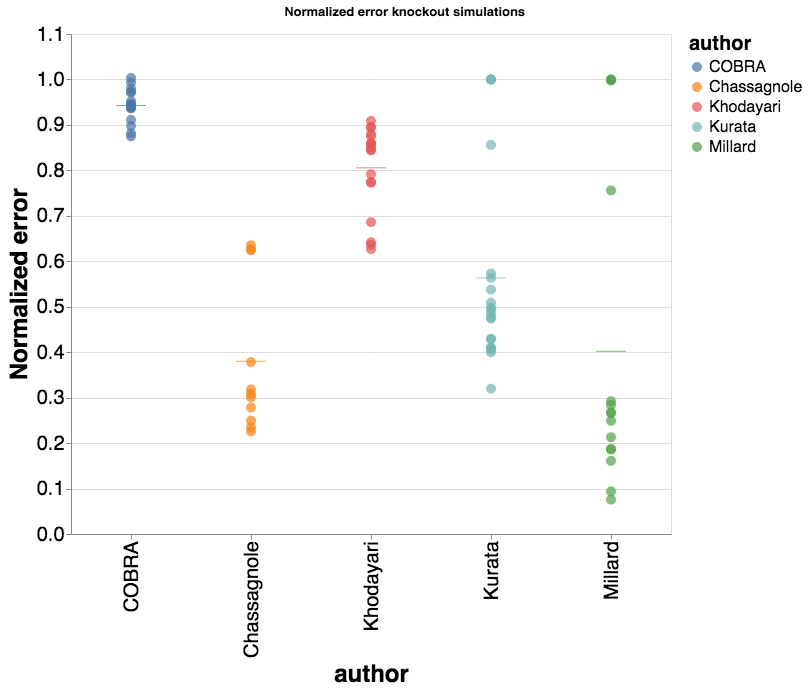

In [57]:
selector = alt.selection_single(empty="all", fields=["sample_id"])
color = alt.condition(
    selector,
    alt.Color("author:N", sort=["Khodayari", "Kurata", "Millard", "COBRA"]),
    alt.value("lightgray"),
)
size = alt.condition(selector, alt.SizeValue(100), alt.SizeValue(40))

# put errors for each dataset as datapoints
errors = (
    alt.Chart(
        normalized_errors.query("author != 'Ishii'"),
        title="Normalized error knockout simulations",
    )
    .mark_circle()
    .encode(
        y=alt.Y("normalized_error", title="Normalized error"),
        color=color,
        tooltip=["author", "sample_id", "normalized_error"],
        x=alt.X(
            "author", sort=["Khodayari", "Kurata", "Millard", "COBRA", "Chassagnole"]
        ),
        size=size
    )
    .add_selection(selector)
)

# add mean values
mean_error = (
    alt.Chart(
        normalized_errors.groupby("author")
        .mean()
        .reset_index()
        .query("author != 'Ishii'")
    )
    .mark_tick(size=30)
    .encode(
        y=alt.Y("normalized_error"),
        color=alt.Color("author", sort=["Khodayari", "Kurata", "Millard", "COBRA"]),
        tooltip=["normalized_error", "author"],
        x=alt.X(
            "author", sort=["Khodayari", "Kurata", "Millard", "COBRA", "Chassagnole"]
        ),
    )
)

(errors + mean_error).properties(width=600, height=500).configure_axis(labelFontSize = 20, titleFontSize = 24).configure_legend(labelFontSize = 16, titleFontSize = 20)

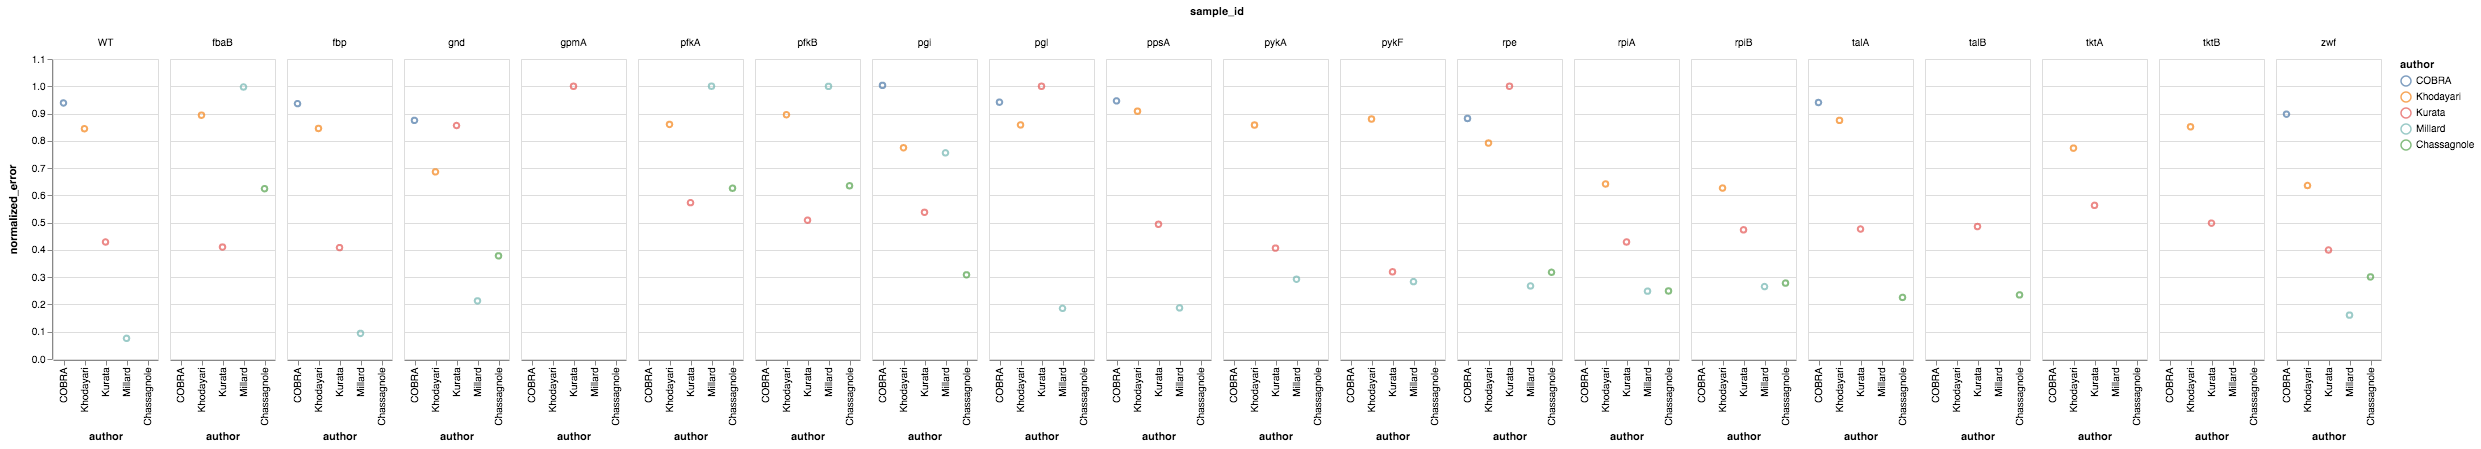

In [36]:
alt.Chart(normalized_errors.query("author != 'Ishii'")).mark_point().encode(
    y="normalized_error",
    x=alt.X("author:O", sort=[experimental_dataset]),
    column="sample_id:N",
    color=alt.Color("author", sort=[experimental_dataset]),
    tooltip=["author", "sample_id"],
)

## Bar chart for normalized fluxes

In [31]:
# make base plot that would be then modified to select only one strain
# altair.facet is not working with them so far
base = alt.Chart(selected_data, title = "KO simulation fluxes").mark_bar().encode(
    y="normalized_flux:Q",
    x=alt.X("author:O", sort = [experimental_dataset]),
    column="BiGG_ID:N",
    color=alt.Color("author", sort = [experimental_dataset]),
    tooltip=["author", "normalized_flux", "BiGG_ID", "sample_id"],
)

@interact_manual
def show_strain_comparison_plot(strain = selected_strains):
    return base.transform_filter(datum.sample_id == strain)

interactive(children=(Dropdown(description='strain', options=('zwf', 'pgi', 'gnd', 'pykA', 'pykF', 'rpiA', 'tk…

## Bar chart for relative error

In [89]:
# make base plot that would be then modified to select only one strain
# altair.facet is not working with them so far
base = alt.Chart(selected, title = "").mark_bar().encode(
    y="relative_error:Q",
    x=alt.X("author:O", sort = [experimental_dataset]),
    column="BiGG_ID:N",
    color=alt.Color("author",sort=[experimental_dataset]),
    tooltip=["author", "relative_error", "BiGG_ID", "sample_id", "normalized_flux"],
)


@interact_manual
def show_strain_comparison_plot(strain = selected_strains):
    return base.transform_filter(datum.sample_id == strain)

interactive(children=(Dropdown(description='strain', options=('zwf', 'pgi', 'gnd', 'pykA', 'pykF', 'WT'), valu…

# Export the data

In [35]:
path = data_path / "Processed"
path.mkdir(parents=True, exist_ok=True)
selected_data.to_csv(path / "knockouts.csv")

In [40]:
selected_data.query("author == 'COBRA' and sample_id == 'pfkA' ")

,BiGG_ID,sample_id,author,flux,normalized_flux,relative_error


In [42]:
cobra_results.query("sample_id == 'pfkAB'")

,ID,flux,sample_id,author,BiGG_ID,normalized_flux
0,ALATA_D2,0.000000e+00,pfkAB,COBRA,ALATA_D2,0.000000e+00
1,SHCHD2,4.237000e-05,pfkAB,COBRA,SHCHD2,1.481469e-03
2,CPPPGO,4.237000e-05,pfkAB,COBRA,CPPPGO,1.481469e-03
3,GTHOr,-8.673617e-19,pfkAB,COBRA,GTHOr,-3.032733e-17
4,DHORD5,0.000000e+00,pfkAB,COBRA,DHORD5,0.000000e+00
5,GLYCTO2,0.000000e+00,pfkAB,COBRA,GLYCTO2,0.000000e+00
6,GLYCTO3,1.271100e-04,pfkAB,COBRA,GLYCTO3,4.444406e-03
7,GLYCTO4,0.000000e+00,pfkAB,COBRA,GLYCTO4,0.000000e+00
8,PFK_3,1.372421e+00,pfkAB,COBRA,PFK_3,4.798677e+01
9,TRPS2,0.000000e+00,pfkAB,COBRA,TRPS2,0.000000e+00
